In [19]:
#!pip install pandas scikit-learn sentence-transformers ipywidgets tqdm


In [20]:
# STEP 1: Imports
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from tqdm import tqdm

In [21]:
# STEP 2: maximize column width for better readability
pd.set_option('display.max_colwidth', None)

In [22]:
# STEP 2: Read CSV
df = pd.read_csv("sample_data.csv")  # change path as needed

In [23]:
# Check dictinct values in 'Categorisation' column
distinct_values = df['Categorisation'].dropna().unique()
print(distinct_values)
print(f"Total distinct values: {len(distinct_values)}")

['FMPS Replaced ' 'Faulty FMPS units causing power issues (MRN Required)'
 'Temp Fix ' 'DPU Replaced' 'Faulty FMPS units causing power issues'
 'Rectifier Issue (Resolved)' 'Replaced Battery' 'DPU Replaced '
 'DPU And Additional Equipment Replaced' 'AC Mains Issues (Electrician)'
 'CB Reset' 'Third Party Power ' 'Tech Not Skilled ']
Total distinct values: 13


In [24]:




# STEP 3: Clean and Standardize closure_summary_alt
def clean_text(text):
    text = str(text).lower() # lowercasing
    text = re.sub(r'\s+', ' ', text) # remove extra space
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.strip()

df['standardized_summary'] = df['closure_summary_alt'].fillna("").apply(clean_text)

# STEP 4: Generate Embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

print("Generating embeddings...")
embeddings = model.encode(df['standardized_summary'].tolist(), show_progress_bar=True)
embeddings = normalize(embeddings)





Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

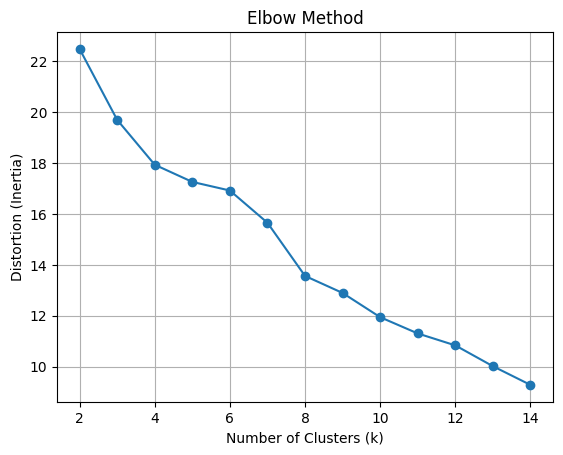

In [25]:
# STEP 5: find optimal number of clusters using the Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.grid(True)
plt.show()


In [26]:
# The "Elbow Method" graph (plotted in cell 6) helps to choose the optimal number of clusters (k) for KMeans.
# On the graph, the x-axis is the number of clusters (k), and the y-axis is the distortion (inertia).
# As k increases, distortion decreases. The "elbow" point is where the rate of decrease sharply slows down.
# Choose k at the elbow point, as adding more clusters beyond this gives diminishing returns.
# In your graph, look for the value of k where the curve bends ("elbow")—this is typically the optimal number of clusters.

In [27]:

# Based on the Elbow Method plot (see cell 6), the best value for k is typically chosen at the "elbow" point—where the distortion (inertia) starts to decrease more slowly as k increases. In your plot, this appears to be # around k=8, which is the value used for clustering in cell 9.

In [28]:
# STEP 5: Cluster Embeddings (KMeans)
n_clusters = 8
print(f"Clustering into {n_clusters} groups...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['semantic_cluster'] = kmeans.fit_predict(embeddings)

# STEP 6: Show Sample Summaries from Each Cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}")
    samples = df[df['semantic_cluster'] == cluster]['standardized_summary'].head(10)
    for i, summary in enumerate(samples):
        print(f"  {i+1}: {summary}")


Clustering into 8 groups...

Cluster 0
  1: 4x 100ah battery replacement complete
  2: 4x 100ah battery replacement complete
  3: 4x 100ah battery replacement complete
  4: 4x 100ah battery replacement complete
  5: 4x 100ah battery replacement complete
  6: 4x 100ah battery replacement complete
  7: 4x 100ah battery replacement complete
  8: 4x 100ah battery replacement complete
  9: 4x 100ah battery replacement complete
  10: 4x 100ah battery replacement is complete

Cluster 1
  1: rcd was tripped upon arrival and after resetting the csd was still off  upon further investigation the fmps was faulty a storm recently hit the area  fmps was replaced with mrn supplied parts  services confirmed restored  noc was also advised to send out sdp electrician to replace the rcd as the âtest trip buttonâ does not trip the circuit  ashish kosta  ashish kumar from noc advised and approved offsite
  2: found that the fmps still had 238v but it was making a ticking a sound the output voltage was 913v

In [29]:
# Check how your semantic clusters align with manual categories
import pandas as pd
pd.crosstab(df['semantic_cluster'], df['Categorisation'])


Categorisation,AC Mains Issues (Electrician),CB Reset,DPU And Additional Equipment Replaced,DPU Replaced,DPU Replaced,FMPS Replaced,Faulty FMPS units causing power issues,Faulty FMPS units causing power issues (MRN Required),Rectifier Issue (Resolved),Replaced Battery,Tech Not Skilled,Temp Fix,Third Party Power
semantic_cluster,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,11,0,0,0
1,0,0,0,0,0,3,1,4,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,2,0
3,6,1,0,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,3,0
5,0,0,0,1,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,3,0
7,0,0,0,0,0,0,0,0,0,6,0,0,0


In [30]:
label_vs_cluster = pd.crosstab(df['Categorisation'], df['semantic_cluster'])
print(label_vs_cluster)


semantic_cluster                                        0  1  2  3  4  5  6  7
Categorisation                                                                
AC Mains Issues (Electrician)                           0  0  0  6  0  0  0  0
CB Reset                                                0  0  0  1  0  0  0  0
DPU And Additional Equipment Replaced                   0  0  1  0  0  0  0  0
DPU Replaced                                            0  0  0  0  0  1  0  0
DPU Replaced                                            0  0  0  0  0  1  0  0
FMPS Replaced                                           0  3  0  0  0  0  0  0
Faulty FMPS units causing power issues                  0  1  0  0  0  0  0  0
Faulty FMPS units causing power issues (MRN Required)   0  4  0  0  0  0  0  0
Rectifier Issue (Resolved)                              0  0  0  1  0  0  0  0
Replaced Battery                                       11  0  0  0  0  0  0  6
Tech Not Skilled                                    

In [31]:
def cluster_purity(df, label_col='Categorisation', cluster_col='semantic_cluster'):
    purity_report = []
    for label in df[label_col].dropna().unique():
        subset = df[df[label_col] == label]
        counts = subset[cluster_col].value_counts()
        majority_cluster = counts.idxmax()
        purity = counts.max() / counts.sum()
        purity_report.append({
            'Label': label,
            'Total Samples': counts.sum(),
            'Majority Cluster': majority_cluster,
            'Purity': round(purity, 2)
        })
    return pd.DataFrame(purity_report).sort_values(by='Purity', ascending=False)

# Run it
purity_df = cluster_purity(df)
print(purity_df)


                                                    Label  Total Samples  \
0                                          FMPS Replaced               3   
1   Faulty FMPS units causing power issues (MRN Required)              4   
3                                            DPU Replaced              1   
4                  Faulty FMPS units causing power issues              1   
5                              Rectifier Issue (Resolved)              1   
12                                      Tech Not Skilled               1   
7                                           DPU Replaced               1   
8                   DPU And Additional Equipment Replaced              1   
9                           AC Mains Issues (Electrician)              6   
10                                               CB Reset              1   
6                                        Replaced Battery             17   
11                                     Third Party Power               2   
2           

Check how your semantic clusters align with manual categories

In [32]:
df['Categorisation'] = df['Categorisation'].astype(str).str.strip().str.lower()

In [33]:
df['Categorisation'] = df['Categorisation'].astype(str).str.strip()

In [34]:
cluster_num = 3  # cluster number
df[df['semantic_cluster'] == cluster_num][['standardized_summary', 'semantic_cluster']].to_csv(f"cluster_{cluster_num}_results.csv", index=False)

In [35]:
df[(df['Categorisation'] == 'replaced battery') & (df['semantic_cluster'] == 0)][['standardized_summary']]

,standardized_summary
13,4x 100ah battery replacement complete
14,4x 100ah battery replacement complete
15,4x 100ah battery replacement complete
16,4x 100ah battery replacement complete
17,4x 100ah battery replacement complete
18,4x 100ah battery replacement complete
19,4x 100ah battery replacement complete
20,4x 100ah battery replacement complete
21,4x 100ah battery replacement complete
22,4x 100ah battery replacement is complete


In [36]:
df[(df['Categorisation'] == 'replaced battery') & (df['semantic_cluster'] == 7)][['standardized_summary']]

,standardized_summary
24,4x 62ah battery replacement complete
25,4x 62ah battery replacement complete
28,8x 62 amp batteries replacement and battery calibration
29,8x 62ah battery replacement complete
30,8x 62ah battery replacement please reference photos attached
31,8x 7ah battery replacement 2x cable looms replacement complete


In [37]:
df[(df['Categorisation'] == 'temp fix') & (df['semantic_cluster'] == 2)][['standardized_summary']]

,standardized_summary
3,10040 cable damaged by lightning activityhaul new 10 pr temporary to provide service and bagged joint do not need permanent fix as n2p is in the pits ready for cutover
4,10040 pr aerial cable damaged temporary repair mudmap submitted for permanent fix


In [38]:
df[(df['Categorisation'] == 'temp fix  ') & (df['semantic_cluster'] == 6)][['standardized_summary']]

,standardized_summary


Example of Generating Embedding

In [39]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Your sample text
text = "RCD was tripped upon arrival, and after resetting the CSD was still off."

# Generate embedding
embedding = model.encode(text)

print(embedding)

[-3.32995132e-02  2.18326896e-02 -8.59158952e-03  3.34905982e-02
  1.14718281e-01  3.37168835e-02 -6.44990951e-02  5.14427125e-02
 -2.58690063e-02  1.90664083e-02  6.71328828e-02  4.51930985e-02
  6.43368140e-02  4.35840413e-02  1.14151658e-02 -2.26448476e-02
  1.05962185e-02 -6.44902214e-02 -5.13617434e-02  4.05700170e-02
 -9.01893526e-02  8.62373859e-02  5.49430307e-03  3.65554877e-02
  1.32596120e-02 -5.81307337e-03 -2.10994780e-02 -5.64503372e-02
  2.72369534e-02  4.56563719e-02 -2.46571433e-02  1.99878141e-02
 -2.47702803e-02 -8.80659930e-03  5.95237762e-02  3.38483825e-02
  6.64703250e-02 -7.67300604e-04 -1.99000016e-02  3.10754385e-02
 -5.05033601e-03  3.66351083e-02 -6.25872537e-02 -1.74464546e-02
  4.31644693e-02  5.07900789e-02  1.95440408e-02 -1.07407816e-01
  2.05265004e-02  2.12223828e-02  3.60639244e-02  5.05436212e-02
 -1.62719376e-02 -2.74885483e-02 -9.09539219e-03  3.92321013e-02
  3.25041339e-02 -2.84655299e-02  9.68953073e-02 -1.00757489e-02
 -3.97156551e-02 -7.02843